# Auto Crop Model

### Import the libraries

In [90]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import json

### Verify the library versions

In [91]:
print('Numpy ' + np.__version__)
print('Tensorflow ' + tf.__version__)

Numpy 1.26.2
Tensorflow 2.15.0


### Model Parameters

In [92]:
tflite_model_name = 'auto_crop'

### Dataset Parameters

In [93]:
input_shape = (256, 192, 3)
n_samples = 170

### Create the dataset

In [94]:
image_dataset = []
anchor_dataset = []

for i in range(0, n_samples):
    # add images
    img = cv.imread(f'./dataset/images/{i}.png')
    image_dataset.append(img / 255)

    # add anchors
    with open(f'dataset/anchors/{i}.json', 'r') as file:
        data = json.load(file)
        anchor = data['shapes'][0]['points']
        anchor = np.array(anchor).astype(dtype=np.int32)
        anchor_map = np.zeros((input_shape[0], input_shape[1], 1), dtype=np.float32)

        cv.fillPoly(anchor_map, [anchor], color=1.0)

    anchor_dataset.append(anchor_map)

image_dataset = np.array(image_dataset, dtype=np.float32)
anchor_dataset = np.array(anchor_dataset, dtype=np.float32)

### Visualize output

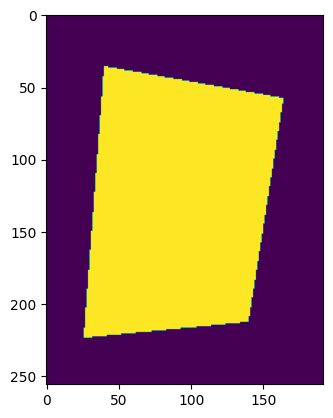

In [95]:
sample = plt.imshow(anchor_dataset[72])
plt.show()

### Create a model

In [96]:
model = keras.Sequential([
    keras.layers.Conv2D(32, 5, activation='relu', padding='same', input_shape=input_shape),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(32, 5, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(32, 5, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(32, 5, activation='relu', padding='same'),
    keras.layers.UpSampling2D(),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(1, 3, padding='same'),
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 256, 192, 32)      2432      
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 128, 96, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 128, 96, 32)       25632     
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 64, 48, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_79 (Conv2D)          (None, 64, 48, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 32, 24, 64)       

In [97]:
history = model.fit(
                image_dataset[:128],
                anchor_dataset[:128],
                epochs=96,
                batch_size=32
)

Epoch 1/96


2023-12-16 11:49:29.915814: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/sequential_7/dropout_31/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


4/4 [==============================] - 2s 102ms/step - loss: 0.6756 - accuracy: 0.6584
Epoch 2/96
4/4 [==============================] - 0s 103ms/step - loss: 0.6540 - accuracy: 0.7574
Epoch 3/96
4/4 [==============================] - 0s 102ms/step - loss: 0.5282 - accuracy: 0.8090
Epoch 4/96
4/4 [==============================] - 0s 100ms/step - loss: 0.3198 - accuracy: 0.8920
Epoch 5/96
4/4 [==============================] - 0s 102ms/step - loss: 0.2450 - accuracy: 0.9079
Epoch 6/96
4/4 [==============================] - 0s 102ms/step - loss: 0.2018 - accuracy: 0.9212
Epoch 7/96
4/4 [==============================] - 0s 101ms/step - loss: 0.2131 - accuracy: 0.9190
Epoch 8/96
4/4 [==============================] - 0s 99ms/step - loss: 0.2016 - accuracy: 0.9175
Epoch 9/96
4/4 [==============================] - 0s 101ms/step - loss: 0.1837 - accuracy: 0.9249
Epoch 10/96
4/4 [==============================] - 0s 101ms/step - loss: 0.1599 - accuracy: 0.9362
Epoch 11/96
4/4 [==============

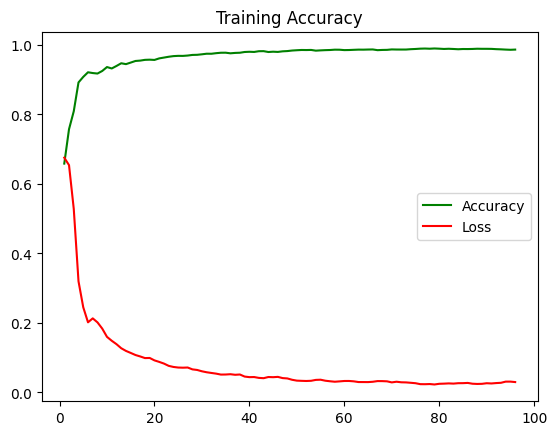

In [98]:
acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'g', label='Accuracy')
plt.plot(epochs, loss, 'r', label='Loss')
plt.title('Training Accuracy')
plt.legend()

### Export model to tflite

In [99]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

open(tflite_model_name + '.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp46ge824b/assets


INFO:tensorflow:Assets written to: /tmp/tmp46ge824b/assets
2023-12-16 11:50:11.086145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-12-16 11:50:11.086171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-12-16 11:50:11.086325: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp46ge824b
2023-12-16 11:50:11.088121: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-12-16 11:50:11.088133: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp46ge824b
2023-12-16 11:50:11.093482: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-12-16 11:50:11.166447: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp46ge824b
2023-12-16 11:50:11.186737: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

1980252

### Test prediction

In [100]:
predictions = model.predict(image_dataset)

6/6 [==============================] - 0s 30ms/step


In [123]:
idx = 161

seg = predictions[idx] > 0.9
out = np.argwhere(seg)[:,:2]

def find_closest_coordinate(point, coordinates):
    distances = np.linalg.norm(coordinates - point, axis=1)
    closest_index = np.argmin(distances)
    return coordinates[closest_index][::-1]

top_left = find_closest_coordinate([0, 0], out)
top_right = find_closest_coordinate([0, 192 - 1], out)
bottom_left = find_closest_coordinate([256 - 1, 0], out)
bottom_right = find_closest_coordinate([256 - 1, 192 - 1], out)

anchor = np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.float32)


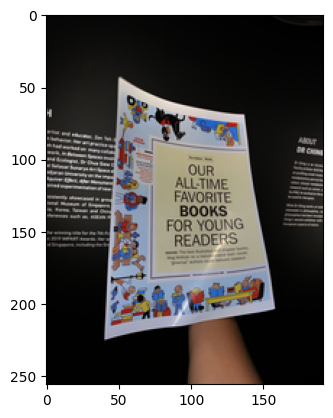

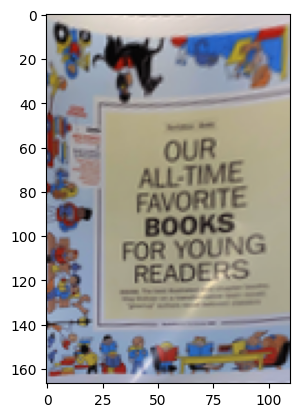

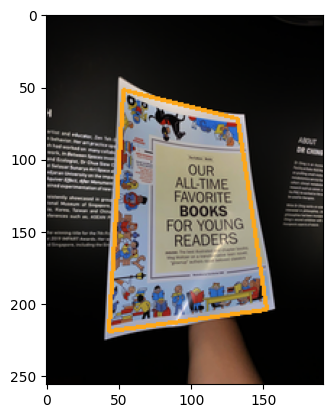

In [124]:
img = cv.imread(f'dataset/images/{idx}.png')
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

sample = plt.imshow(img)
plt.show()

rect = anchor
tl, tr, br, bl = anchor

x1 = np.linalg.norm(br - bl)
x2 = np.linalg.norm(tr - tl)

y1 = np.linalg.norm(tr - br)
y2 = np.linalg.norm(tl - bl)

w = max(int(x1), int(x2))
h = max(int(y1), int(y2))

dst = np.array([
	[0, 0],
	[w - 1, 0],
	[w - 1, h - 1],
	[0, h - 1]], dtype = "float32")

M = cv.getPerspectiveTransform(rect, dst)
warp = cv.warpPerspective(img, M, (w, h))

sample = plt.imshow(warp)
plt.show()

tl, tr, br, bl = anchor.astype(dtype=np.int32)
cv.line(img, tl, tr, (254, 167, 24), 2)
cv.line(img, tr, br, (254, 167, 24), 2)
cv.line(img, br, bl, (254, 167, 24), 2)
cv.line(img, bl, tl, (254, 167, 24), 2)

sample = plt.imshow(img)
plt.show()